# Assignment 2: The "Smart Labeling Pipeline" Challenge

**Total Marks: 20**

Build a cost-effective, high-quality labeling pipeline using human annotation, programmatic rules, and LLMs.

This notebook implements an end-to-end smart labeling pipeline to:
1. Establish gold standard through human annotation and measure inter-annotator agreement (6 marks)
2. Label data programmatically using weak supervision (Snorkel) (6 marks)
3. Optimize labeling budget using active learning (5 marks)
4. Leverage LLMs for bulk labeling and detect hallucinations (e.g. noisy labels) (3 marks)

## Setup and Imports

In [7]:
%pip install snorkel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 4.5 MB/s eta 0:00:00


In [8]:
# Import required libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel
from statsmodels.stats.inter_rater import fleiss_kappa
import google.generativeai as genai
import time
from pathlib import Path
import re

/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)


## Task 1: The Human as Annotator (6 Marks)

**Objective:** Establish a "Gold Standard" dataset and measure human consensus.

### Part 1.1: Parse Annotator CSV Files

After annotating the first 100 reviews, export annotations from three annotators (A, B, C) as CSV files.
Parse these CSV files into clean DataFrames for analysis.

In [9]:
def parse_annotator_csv(csv_path):
    """
    Parses annotator CSV file into a clean DataFrame.
    
    Args:
        csv_path (str): Path to annotator CSV file
        
    Returns:
        pd.DataFrame: DataFrame with columns ['review_id', 'review', 'label']
                     where label is one of: 'Positive', 'Negative', 'Neutral'
    
    Note:
        - Look for relevant column names in the CSV file
        - If column names differ, the function will try to map them appropriately
        - Finally, return with two columns 'review' and 'label'
    """
    # TODO: Load CSV file using pd.read_csv()
    df = pd.read_csv(csv_path)
    # TODO: Check and map column names if needed
    df.columns = [col.strip().lower() for col in df.columns] # lower the column name
    if 'review_id' not in df.columns:
        df['review_id'] = df.index  # create id = index if review_id column is not present
    if 'review' not in df.columns:
        raise ValueError("CSV must contain a 'review' column")
    if 'sentiment' not in df.columns:
        raise ValueError("CSV must contain a 'sentiment' column")
    
    return df[['review_id', 'review', 'sentiment']].rename(columns={'sentiment': 'label'})

In [ ]:
# TODO: Parse CSV files (replace with actual file paths)
df_a = parse_annotator_csv('./annotator_a.csv')
df_b = parse_annotator_csv('./annotator_b.csv')
df_c = parse_annotator_csv('./annotator_c.csv')
# Display sample data
print("="*20, "Annotator A", "="*20)
print(df_a.head())
print("="*20, "Annotator B", "="*20)
print(df_b.head())
print("="*20, "Annotator C", "="*20)
print(df_c.head())

FileNotFoundError: [Errno 2] No such file or directory: './annotator_a.csv'

### Part 1.2: Implement Fleiss' Kappa from Scratch

Measure inter-annotator agreement using Fleiss' Kappa statistic.
Implement the formula from scratch and compare with statsmodels implementation.

In [ ]:
def fleiss_kappa_scratch(rating_matrix):
    """
    Computes Fleiss' Kappa for multiple raters from scratch.
    
    Args:
        rating_matrix (np.array): A Count Matrix of shape (N, k).
                                  - N = number of items (rows)
                                  - k = number of categories (columns)
                                  - Element [i, j] = Count of raters who assigned category j to item i.
                                  Example: 
                                    [[0, 0, 3],   # Item 0: All 3 raters said Category 2
                                     [1, 2, 0]]   # Item 1: 1 rater said Cat 0, 2 said Cat 1
                            
    
    Returns:
        float: Kappa score (ranges from -1 to 1, where 1 = perfect agreement)
    
    Formula:
        κ = (P_bar - P_e_bar) / (1 - P_e_bar)
        
        where:
        - P_bar = (1/N) * Σ(P_i) = average proportion of agreement across all items
        - P_i = (1/(n*(n-1))) * Σ(k_ij * (k_ij - 1)) for item i
        - P_e_bar = Σ(p_j^2) = expected agreement by chance
        - p_j = proportion of all assignments to category j
    
    Note:
        - N = number of items (samples)
        - n = number of raters per item (should be constant)
        - k_ij = number of raters who assigned category j to item i
    """
    # TODO: Calculate P_bar (observed agreement), P_e_bar (expected agreement by chance), Apply the formula: κ = (P_bar - P_e_bar) / (1 - P_e_bar)
    n = np.sum(rating_matrix[0]) # number of rater per item
    p_i = (1/(n*(n-1))) * np.sum(rating_matrix * (rating_matrix - 1), axis=1) # p_i for each item
    P_bar = np.mean(p_i) # Observed agreement
    p_j = np.sum(rating_matrix, axis=0) / (np.sum(rating_matrix)) # proportion of all assignments
    P_e_bar = np.sum(p_j ** 2) # Expected agreement
    kappa = (P_bar - P_e_bar) / (1 - P_e_bar) # Fleiss's Kappa
    return kappa

In [ ]:
def prepare_rating_matrix(df_a, df_b, df_c):
    """
    Converts three DataFrames into a rating matrix for Fleiss' Kappa calculation.
    
    Args:
        df_a, df_b, df_c: DataFrames with columns ['review_id', 'review', 'label']
        
    Returns:
        np.array: Rating matrix of shape (N_samples, N_categories)
                  where categories are ['Negative', 'Neutral', 'Positive']
    """
    # TODO: Merge the three DataFrames on review
    # Hint: Use pd.merge() or pd.concat() with proper keys
    df_merged = (df_a.merge(
        df_b, on=['review_id', 'review'], suffixes=('_a', '_b'))
        .merge(df_c, on=['review_id', 'review'])
        .rename(columns={'label': 'label_c'})
    ) # merge array on review_id and review column and rename label columns
    
    # TODO: Return numpy array of shape (N_samples, 3)
    # Order: [Negative_count, Neutral_count, Positive_count] for each row
    category_mapping = {'Negative': 0, 'Neutral': 2, 'Positive': 1} # catgory mapping
    rating_matrix = np.zeros((df_merged.shape[0], 3), dtype=int) # initialize rating matrix
    for idx, row in df_merged.iterrows():
        labels = [row['label_a'], row['label_b'], row['label_c']] # extract labels from the row
        for label in labels:
            rating_matrix[idx, category_mapping[label]] += 1
            
    return rating_matrix

# TODO: Prepare rating matrix and calculate Fleiss' Kappa
rating_matrix = prepare_rating_matrix(df_a, df_b, df_c) # prepare rating matrix
kappa_scratch = fleiss_kappa_scratch(rating_matrix) # calculate kappa from scratch
# TODO: Use statsmodels to calculate Fleiss' Kappa
kappa_statsmodels = fleiss_kappa(rating_matrix) # calculate kappa using statsmodels
# TODO: Print the difference between the two implementations
print("Fleiss' Kappa (Scratch):", kappa_scratch)
print("Fleiss' Kappa (Statsmodels):", kappa_statsmodels)
print("Difference between the two implementations:", kappa_scratch - kappa_statsmodels)

Fleiss' Kappa (Scratch): 0.784453263993431
Fleiss' Kappa (Statsmodels): 0.784453263993431
Difference between the two implementations: 0.0


### Part 1.3: Conflict Resolution

Identify conflicts where annotators disagree and resolve them using majority vote.
For complete ties (all three differ), default to 'Neutral'.

In [ ]:
def resolve_conflicts(df_a, df_b, df_c):
    """
    Merges annotations from 3 annotators, resolves disagreements using Majority Vote,
    and handles complete ties by defaulting to 'Neutral'.
    
    Args:
        df_a, df_b, df_c: DataFrames from each annotator with columns ['review', 'label']
        
    Returns:
        pd.DataFrame: Final DataFrame with resolved labels (gold standard)
                     Columns: ['review', 'label']
    
    Logic:
        - Majority Vote: If 2 annotators agree, use their label
        - Tie-Breaker: If all 3 differ (e.g., Positive vs. Negative vs. Neutral), assign 'Neutral'
    """
    df_merged = (df_a.merge(
        df_b, on=['review_id', 'review'], suffixes=('_a', '_b'))
        .merge(df_c, on=['review_id', 'review'])
        .rename(columns={'label': 'label_c'})
    )
    
    def majority_vote(row):
        labels = [row['label_a'], row['label_b'], row['label_c']]
        if labels.count(labels[0]) >= 2:  # If at least 2 annotators agree
            return labels[0]
        elif labels.count(labels[1]) >= 2:
            return labels[1]
        elif labels.count(labels[2]) >= 2:
            return labels[2]
        else:
            return 'Neutral'  # If all three differ assign Neutral
        
    df_merged['resolved_label'] = df_merged.apply(majority_vote, axis=1) # apply majority vote to resolve conflicts
    conflicts = df_merged[(df_merged[['label_a', 'label_b', 'label_c']].nunique(axis=1) > 2)] # identify conflicts where all labels are different
    return df_merged[['review', 'resolved_label']].rename(columns={'resolved_label': 'label'}), conflicts # return df with columns review and label

In [ ]:
# TODO: Resolve conflicts and create gold standard
df_gold_standard, conflicts = resolve_conflicts(df_a, df_b, df_c)
# TODO: Display 5 examples of conflicting reviews (if <5 reviews, show all)
# Show what A, B, and C each said, and the final resolved label
print("="*20, "Conflicts", "="*20)
print("Total Conflicts:", conflicts.shape[0])
print(conflicts.head(5))

# TODO: Save gold standard to CSV
df_gold_standard.to_csv('gold_standard_100.csv', index=False) # save gold standard to csv

==================== Conflicts ====================
Total Conflicts: 0
Empty DataFrame
Columns: [review_id, review, label_a, label_b, label_c, resolved_label]
Index: []


## Task 2: Weak Supervision (The "Lazy" Labeler) (6 Marks)

**Objective:** Label the next 200 reviews programmatically to save time.

### Part 2.1: Heuristic Development

Analyze patterns in the gold standard and write at least 3 heuristic functions.
Apply them to the remaining 200 unlabeled reviews.

In [ ]:
# Constants for labeling functions
POSITIVE = 1
NEGATIVE = 0
NEUTRAL = 2
ABSTAIN = -1

# TODO: Load gold standard to analyze patterns
df_gold_standard = pd.read_csv('./gold_standard_100.csv') # load gold standard csv

# TODO: Analyze patterns (e.g., common positive/negative words, review length, etc.)
# This will help you design effective heuristics

### Part 2.2: Snorkel Labeling Functions

Wrap your heuristics as Snorkel @labeling_function decorators.
Each function should return POSITIVE (1), NEGATIVE (0), NEUTRAL (2), or ABSTAIN (-1).

In [ ]:
@labeling_function()
def lf_keyword_great(x):
    """
    Example labeling function: Check if "great" appears in the review.
    Returns POSITIVE if found, otherwise ABSTAIN.
    """
    # TODO: Check if "great" (case-insensitive) is in x.review
    # Return POSITIVE if found, ABSTAIN otherwise
    return POSITIVE if "great" in x.review.lower() else ABSTAIN

@labeling_function()
def lf_short_review(x):
    """
    Label based on review length.
    Very short reviews might be neutral or indicate lack of engagement.
    """
    # TODO: Implement logic based on review length
    # Return appropriate label (NEUTRAL for very short, or ABSTAIN)
    return NEUTRAL if len(x.review) < 20 else ABSTAIN

@labeling_function()
def lf_regex_bad(x):
    """
    Use regex to find negative patterns.
    Look for words like "horrible", "terrible", "awful", etc.
    """
    # TODO: Use regex or string matching to find negative keywords
    # Return NEGATIVE if found, ABSTAIN otherwise
    words = ["horrible", "terrible", "awful", "worst", "zero", "garbage", "waste", "disappointing", "avoid", "misfire"]
    return NEGATIVE if any(word in x.review.lower() for word in words) else ABSTAIN

# TODO: Write at least 3 more labeling functions (minimum 6 total)
@labeling_function()
def lf_regex_positive(x):
    """
    Use regex to find positive patterns.
    Look for words like "amazing", "fantastic", "love", etc.
    """
    words = ["triumph", "perfect", "masterpiece", "hooked"]
    return POSITIVE if any(word in x.review.lower() for word in words) else ABSTAIN

@labeling_function()
def lf_keyword_wow(x):
    """
    Check if "wow" appears in the review.
    Returns POSITIVE if found, otherwise ABSTAIN.
    """
    return POSITIVE if "wow" in x.review.lower() else ABSTAIN

@labeling_function()
def lf_keyword_bored(x):
    """
    Check if "bored" appears in the review.
    Returns NEGATIVE if found, otherwise ABSTAIN.
    """
    return NEGATIVE if "bored" in x.review.lower() else ABSTAIN

@labeling_function()
def lf_keyword_fine(x):
    """
    Check if "fine" appears in the review.
    Returns NEUTRAL if found, otherwise ABSTAIN.
    """
    return NEUTRAL if "fine" in x.review.lower() else ABSTAIN

@labeling_function()
def lf_regex_neutral(x):
    """
    Use regex to find neutral patterns.
    Look for words like "fine", "confused", etc.
    """
    words = ["confused", "oscillated", "forgettable", "average", "categorize", "strange", "mixed"]
    return NEUTRAL if any(word in x.review.lower() for word in words) else ABSTAIN

### Part 2.3: Apply Labeling Functions and Analyze Coverage

Apply all labeling functions to the 200 unlabeled reviews and calculate coverage and conflict rates.

In [ ]:
def analyze_weak_labels(L_matrix, lfs):
    """
    Prints Coverage and Conflict statistics for the Labeling Functions.
    
    Args:
        L_matrix (np.array): Label matrix of shape (N_samples, N_functions)
                            Each column represents one labeling function's outputs
                            Values: POSITIVE (1), NEGATIVE (0), NEUTRAL (2), ABSTAIN (-1)
        lfs: List of labeling functions (for display names)
    
    Metrics to calculate:
        - Coverage: Percentage of non-abstain votes per LF
        - Conflict Rate: Percentage of samples where LFs disagree
    """
    # TODO: Calculate coverage for each labeling function
    # Coverage = (number of non-abstain votes) / (total samples) * 100
    
    coverage = []
    for i in range(L_matrix.shape[1]):
        non_abstain_count = np.sum(L_matrix[:, i] != ABSTAIN)
        coverage.append((non_abstain_count / L_matrix.shape[0]) * 100)
    
    # TODO: Calculate conflict rate
    # Conflict occurs when multiple LFs label the same sample differently
    # Conflict Rate = (number of conflicting samples) / (total samples) * 100
    conflict_count = 0
    for i in range(L_matrix.shape[0]):
        unique_labels = set(L_matrix[i, :])
        if ABSTAIN in unique_labels:
            unique_labels.remove(ABSTAIN)
        if len(unique_labels) > 1:
            conflict_count += 1
    conflict_rate = (conflict_count / L_matrix.shape[0]) * 100
    
    # TODO: Print statistics in a readable format
    # Hint: Use LFAnalysis from snorkel for detailed stats (optional)
    # Or print manually: LF name, Coverage %, Conflicts count
    for i, lf in enumerate(lfs):
        print(f"LF: {lf}, Coverage: {coverage[i]:.2f}%, Conflicts: {conflict_rate:.2f}%")

# TODO: Load the 200 unlabeled reviews (you can load the entire dataset and then filter as per the requirement)
df_unlabeled = pd.read_csv('Movie_review - unique_movie_reviews.csv').loc[100:]

# TODO: Apply all labeling functions to create L_matrix
lfs = [lf_keyword_great, lf_short_review, lf_regex_bad, lf_keyword_wow, lf_keyword_bored, lf_regex_positive, lf_keyword_fine, lf_regex_neutral]  # Add all your LFs
applier = PandasLFApplier(lfs=lfs) # create a pandas lf applier
L_matrix = applier.apply(df=df_unlabeled) # create L_matrix

# TODO: Analyze c
# overage and conflicts
analyze_weak_labels(L_matrix, lfs)

# TODO: Use LFAnalysis for detailed statistics
analysis = LFAnalysis(L=L_matrix, lfs=lfs)
print(analysis.lf_summary())

100%|██████████| 220/220 [00:00<00:00, 5285.89it/s]

LF: LabelingFunction lf_keyword_great, Preprocessors: [], Coverage: 5.00%, Conflicts: 3.18%
LF: LabelingFunction lf_short_review, Preprocessors: [], Coverage: 0.00%, Conflicts: 3.18%
LF: LabelingFunction lf_regex_bad, Preprocessors: [], Coverage: 16.36%, Conflicts: 3.18%
LF: LabelingFunction lf_keyword_wow, Preprocessors: [], Coverage: 3.18%, Conflicts: 3.18%
LF: LabelingFunction lf_keyword_bored, Preprocessors: [], Coverage: 3.18%, Conflicts: 3.18%
LF: LabelingFunction lf_regex_positive, Preprocessors: [], Coverage: 11.82%, Conflicts: 3.18%
LF: LabelingFunction lf_keyword_fine, Preprocessors: [], Coverage: 10.45%, Conflicts: 3.18%
LF: LabelingFunction lf_regex_neutral, Preprocessors: [], Coverage: 18.64%, Conflicts: 3.18%
                   j Polarity  Coverage  Overlaps  Conflicts
lf_keyword_great   0      [1]  0.050000  0.009091   0.009091
lf_short_review    1       []  0.000000  0.000000   0.000000
lf_regex_bad       2      [0]  0.163636  0.013636   0.004545
lf_keyword_wow     3   


c:\projects\Courses\sttai\.venv\Lib\site-packages\snorkel\labeling\analysis.py:61: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
  m = sparse.diags(np.ravel(self._L_sparse.max(axis=1).todense()))


### Part 2.4: Majority Vote Adjudication

Use majority vote to generate probabilistic labels (weak labels) for the 200 reviews.
Save the result to `weak_labels_200.csv`.

In [ ]:
# TODO: Train LabelModel to get probabilistic labels
label_model = LabelModel(cardinality=3, verbose=True) # create label model with 3 classes
label_model.fit(L_train=L_matrix, n_epochs=500, log_freq=100, seed=42)

# TODO: Convert numeric labels to match your label scheme
# Label mapping: 0 -> 'Negative' (or 0), 1 -> 'Positive' (or 1), 2 -> 'Neutral' (or 2), -1 -> 'Abstain'
probabilistic_labels = label_model.predict_proba(L=L_matrix) # get probabilistic labels
numeric_labels = label_model.predict(L=L_matrix) # get numeric labels
label_mapping = {0: 'Negative', 1: 'Positive', 2: 'Neutral', -1: 'Abstain'} # label mapping
string_labels = [label_mapping[num] for num in numeric_labels] # convert numeric labels to string labels

# TODO: Create DataFrame with reviews and weak labels
df_weak_labels = df_unlabeled.copy()
df_weak_labels['weak_label'] = string_labels

# TODO: Save to CSV
df_weak_labels.to_csv('weak_labels_200.csv', index=False)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████| 500/500 [00:00<00:00, 793.41epoch/s]
INFO:root:Finished Training


## Task 3: Active Learning (The Budget Optimizer) (5 Marks)

**Objective:** Simulate cost savings by training a model iteratively.

### Part 3.1: Query Strategy Implementation

Implement Least Confidence and Entropy Sampling from scratch.
These strategies select the most informative samples for labeling.

In [ ]:
def least_confidence_sampling(model, X_pool, n_instances=10):
    """
    Selects samples where the model is least confident (uncertainty sampling).
    
    Args:
        model: Trained classifier with predict_proba() method
        X_pool: Feature matrix of unlabeled samples
        n_instances: Number of samples to select
    
    Returns:
        np.array: Indices of selected samples
        
    Strategy:
        Uncertainty = 1 - max(probability) across all classes
        For 3-class classification: Get probabilities for [Negative, Positive, Neutral]
        Select samples with highest uncertainty (lowest max probability)
    """
    # TODO: Get probability predictions from model
    probs = model.predict_proba(X_pool)
    
    # TODO: Calculate uncertainty: 1 - max(probability) for each sample
    max_probs = np.max(probs, axis=1)
    uncertainty = 1 - max_probs

    # TODO: Select top n_instances samples with highest uncertainty
    selected_indices = np.argsort(uncertainty)[::-1][:n_instances]
    return selected_indices

def entropy_sampling(model, X_pool, n_instances=10):
    """
    Selects samples with highest entropy (information gain).
    
    Args:
        model: Trained classifier with predict_proba() method
        X_pool: Feature matrix of unlabeled samples
        n_instances: Number of samples to select
    
    Returns:
        np.array: Indices of selected samples
        
    Strategy:
        Entropy = -sum(p * log(p)) for all classes
        For 3-class classification: Calculate entropy across [Negative, Positive, Neutral] probabilities
        Select samples with highest entropy (most uncertain across all classes)
    """
    # TODO: Get probability predictions from model
    probs = model.predict_proba(X_pool)
    
    # TODO: Calculate entropy: -sum(p * log(p)) for each sample
    # Add small epsilon (1e-9) to avoid log(0) errors
    epsilon = 1e-9
    probs = np.clip(probs, epsilon, 1 - epsilon)
    entropy = -np.sum(probs * np.log(probs), axis=1)

    # TODO: Select top n_instances samples with highest entropy
    selected_indices = np.argsort(entropy)[::-1][:n_instances]
    return selected_indices

def random_sampling(model, X_pool, n_instances=10):
    """
    Baseline strategy: Selects random samples.
    
    Args:
        model: Not used, but kept for interface consistency
        X_pool: Feature matrix of unlabeled samples
        n_instances: Number of samples to select
    
    Returns:
        np.array: Randomly selected indices
    """
    # TODO: Randomly select n_instances indices from X_pool
    n_samples = X_pool.shape[0]
    selected_indices = np.random.choice(n_samples, size=n_instances, replace=False)
    return selected_indices

### Part 3.2: Data Processing and Setup

Load the gold standard (seed) and weak labels (pool).
Create a static test set from the pool for evaluation.
Vectorize text data using TF-IDF.

In [ ]:
def load_and_process_data():
    """
    Loads and processes data for active learning.
    
    Returns:
        Tuple: (X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer)
               All X are feature matrices, all y are label arrays
               vectorizer is returned for later use on LLM data
               
    Note:
        - Seed: gold_standard_100.csv (100 labeled reviews)
        - Pool: weak_labels_200.csv (200 reviews, labels treated as hidden for simulation)
        - Test: Hold out 50 samples from pool (weak labels) for static evaluation
        - We use 3-class classification: Positive (1), Negative (0), Neutral (2)
        - Uncertainty metrics use probability scores across all three classes:
          * Least Confidence: 1 - max(probabilities) across all classes
          * Entropy: -sum(p * log(p)) for all three classes
    """

    df_seed = pd.read_csv('gold_standard_100.csv')
    df_pool_full = pd.read_csv('weak_labels_200.csv')
    
    # Ensure both have 'review' column
    if 'review' not in df_seed.columns:
        raise ValueError("gold_standard_100.csv must have 'review' column")
    if 'review' not in df_pool_full.columns:
        raise ValueError("weak_labels_200.csv must have 'review' column")
    
    # Handle both 'label' and 'sentiment' column names
    def get_actual_column(df, possible_names):
        # Check for exact or case-insensitive matches
        for col in df.columns:
            if col.lower() in possible_names:
                return col
        # If not found, crash with a HELPFUL error message
        raise KeyError(f"Could not find label column. looked for: {possible_names}. Found in file: {list(df.columns)}")

    label_col_seed = get_actual_column(df_seed, ['label', 'sentiment','weak_label'])
    label_col_pool = get_actual_column(df_pool_full, ['label', 'sentiment', 'weak_label'])
    # --- FIX END ---
    
    # Map text labels to numeric: Positive=1, Negative=0, Neutral=2
    label_mapping = {
        'Positive': 1, 'positive': 1, 'POSITIVE': 1,
        'Negative': 0, 'negative': 0, 'NEGATIVE': 0,
        'Neutral': 2, 'neutral': 2, 'NEUTRAL': 2,
        'abstain': -1, 'Abstain': -1, 'ABSTAIN': -1
    }
    
    # Convert seed labels
    if df_seed[label_col_seed].dtype == 'object':
        df_seed['sentiment_numeric'] = df_seed[label_col_seed].astype(str).str.strip().map(label_mapping)
        if df_seed['sentiment_numeric'].isna().any():
            raise ValueError(f"Unknown labels in seed data: {df_seed[df_seed['sentiment_numeric'].isna()][label_col_seed].unique()}")
    else:
        df_seed['sentiment_numeric'] = df_seed[label_col_seed].values
    
    # Convert pool labels
    if df_pool_full[label_col_pool].dtype == 'object':
        df_pool_full['sentiment_numeric'] = df_pool_full[label_col_pool].map(label_mapping)
        if df_pool_full['sentiment_numeric'].isna().any():
            raise ValueError(f"Unknown labels in pool data: {df_pool_full[df_pool_full['sentiment_numeric'].isna()][label_col_pool].unique()}")
    else:
        df_pool_full['sentiment_numeric'] = df_pool_full[label_col_pool].values
    
    # Create static test set (hold out 50 samples from pool)
    df_pool, df_test = train_test_split(df_pool_full, test_size=50, random_state=42)
    
    # Vectorize text data using TfidfVectorizer
    # Fit vectorizer on ALL text (seed + pool + test) to ensure consistent dimensions
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    all_text = pd.concat([df_seed['review'], df_pool['review'], df_test['review']])
    vectorizer.fit(all_text)
    
    # Transform datasets to feature matrices
    X_seed = vectorizer.transform(df_seed['review']).toarray()
    X_pool = vectorizer.transform(df_pool['review']).toarray()
    X_test = vectorizer.transform(df_test['review']).toarray()
    
    # Extract numeric labels
    y_seed = df_seed['sentiment_numeric'].values
    y_pool = df_pool['sentiment_numeric'].values
    y_test = df_test['sentiment_numeric'].values
    
    # Return all datasets and vectorizer
    return X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer

# TODO: uncomment below codes, to use these variables further
X_seed, y_seed, X_pool, y_pool, X_test, y_test, vectorizer = load_and_process_data()

print(f"Seed Size: {len(y_seed)}")
print(f"Pool Size: {len(y_pool)} (Available for querying)")
print(f"Test Size: {len(y_test)} (Held out for evaluation)")

Seed Size: 100
Pool Size: 170 (Available for querying)
Test Size: 50 (Held out for evaluation)


### Part 3.3: Active Learning Loop

Implement the iterative active learning loop:
1. Train model on current training set
2. Query uncertain samples from pool
3. "Label" them (reveal ground truth)
4. Add to training set and retrain
5. Log test accuracy

In [ ]:
def run_active_learning_loop(X_seed, y_seed, X_pool, y_pool, X_test, y_test, 
                             strategy_func, steps=5, batch_size=10):
    """
    Simulates the active learning loop (matches lab approach).
    
    Args:
        X_seed, y_seed: Initial training data (seed set)
        X_pool, y_pool: Unlabeled pool (y_pool is hidden, revealed during query)
        X_test, y_test: Static test set for evaluation
        strategy_func: Function that selects samples (e.g., least_confidence_sampling)
                      Signature: strategy_func(model, X_pool, n_instances) -> indices
        steps: Number of iterations
        batch_size: Number of samples to query per iteration
    
    Returns:
        Tuple: (n_labels_history, accuracy_history)
               Lists tracking number of labels and test accuracy over iterations
    """
    # TODO: Initialize training set with seed data
    X_train, y_train = X_seed, y_seed
    
    # TODO: Create working copies of pool (we'll remove samples as we query them)
    X_pool_curr = X_pool.copy()
    y_pool_curr = y_pool.copy()
    
    # TODO: Initialize empty lists to track progress (accuracy_history, n_labels_history)
    accuracy_history = []
    n_labels_history = []

    
    # Train initial model on seed data
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)
    
    # TODO: Evaluate initial model and log results
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_history.append(acc)
    n_labels_history.append(len(y_train))

    
    # TODO: Iterative loop (repeat 'steps' times):
    #   for i in range(steps):
    #       1. Query: Use strategy_func(model, X_pool_curr, batch_size) to get indices
    #       2. "Label": Reveal ground truth: y_new = y_pool_curr[query_indices]
    #       3. Add to training set: use np.vstack() to add new samples
    #       4. Remove from pool: use np.delete() to remove queried samples
    #       5. Retrain model: use model.fit() to update the model
    #       6. Evaluate on test set, get accuracy
    #       7. Log: accuracy_history.append(acc), n_labels_history.append(len(y_train))
    for i in range(steps):
        query_indices = strategy_func(model, X_pool_curr, batch_size) # query samples using strategy function
        y_new = y_pool_curr[query_indices] # reveal ground truth labels for queried samples
        X_new = X_pool_curr[query_indices] # get feature vectors for queried samples
        X_train = np.vstack((X_train, X_new)) # add new samples to training set
        y_train = np.concatenate((y_train, y_new)) # add new labels to training set
        X_pool_curr = np.delete(X_pool_curr, query_indices, axis=0) # remove queried samples from pool
        y_pool_curr = np.delete(y_pool_curr, query_indices, axis=0) # remove corresponding labels from pool
        model.fit(X_train, y_train) # retrain model with updated training set
        y_pred = model.predict(X_test) # evaluate on test set
        acc = accuracy_score(y_test, y_pred) # calculate accuracy
        accuracy_history.append(acc) # log accuracy
        n_labels_history.append(len(y_train)) # log number of labels in training set


    # TODO: Return history lists
    return n_labels_history, accuracy_history

# TODO: Run active learning with least confidence strategy
n_labels_lc, acc_lc = run_active_learning_loop(X_seed, y_seed, X_pool, y_pool, X_test, y_test, least_confidence_sampling, steps=10)

### Part 3.4: Visualization and Comparison

Plot learning curves comparing Active Learning vs. Random Sampling.

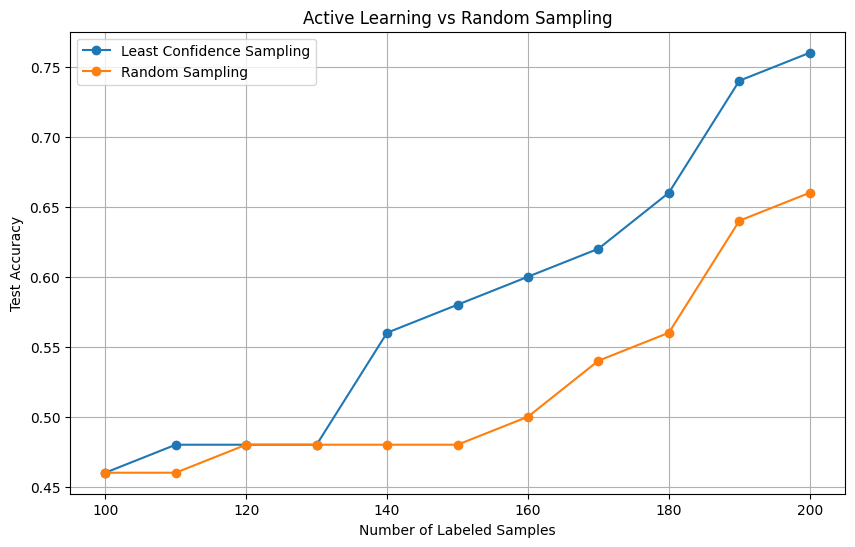

Final accuracy for Least Confidence Sampling: 0.760
Final accuracy for Random Sampling: 0.660


In [ ]:
# TODO: Run active learning with random sampling (baseline)
# TODO: Plot learning curves of active learning and random sampling wrt to number of samples
n_labels_random, acc_random = run_active_learning_loop(X_seed, y_seed, X_pool, y_pool, X_test, y_test, random_sampling, steps=10)
plt.figure(figsize=(10, 6))
plt.plot(n_labels_lc, acc_lc, marker='o', label='Least Confidence Sampling')
plt.plot(n_labels_random, acc_random, marker='o', label='Random Sampling')
plt.title('Active Learning vs Random Sampling')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid()
plt.show()


# TODO: Print comparison summary for active learning and random sampling final accuracy
print(f"Final accuracy for Least Confidence Sampling: {acc_lc[-1]:.3f}")
print(f"Final accuracy for Random Sampling: {acc_random[-1]:.3f}")


## Task 4: AI vs. AI (LLM & Noise Detection) (3 Marks)

**Objective:** Use LLMs for bulk labeling and detect hallucinations.

**Note:**

- Make an account at [open-router](https://openrouter.ai/) and get the API key.
- Use `google/gemini-2.5-flash-lite` (free tier) model as your LLM. Read the documentation on how to use it [here](https://openrouter.ai/google/gemini-2.5-flash-lite/api)
- Set environment variable using .env file and paste your API key in it.

### Part 4.1: LLM Pipeline with Few-Shot Prompting

Design a few-shot prompt with 3 examples from gold standard.
Send remaining unlabeled samples (~150) to Gemini API for labeling.

In [ ]:

import os
import time
import json
import requests
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path

# Robust path resolution
try:
    # Try to get the directory of the current script
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    # Fallback to current working directory (e.g., in Jupyter)
    BASE_DIR = Path.cwd()

# Load environment variables with override
env_path = BASE_DIR / '.env'
if env_path.exists():
    load_dotenv(dotenv_path=env_path, override=True)

else:
    # print(f"Warning: .env not found at {env_path}")
    # Try loading from current directory if different
    load_dotenv(override=True)

API_KEY = os.getenv('OPENROUTER_API_KEY')
SITE_URL = "http://localhost:8000"
SITE_NAME = "Student Lab Assignment"
MODEL_NAME = "google/gemini-2.5-flash-lite" 

if not API_KEY:
    print("⚠ Warning: OPENROUTER_API_KEY not found. Check .env file.")

def generate_batch_prompt(reviews, examples):
    """
    Constructs a prompt for a batch of reviews.
    """
    prompt = "Task: Classify the sentiment of the following movie reviews as 'Positive', 'Negative', or 'Neutral'.\n"
    prompt += "Output Format: Provide a raw JSON list of strings. Do not use Markdown. Example: [\"Positive\", \"Negative\"]\n\n"
    
    prompt += "Few-shot Examples:\n"
    for ex in examples:
        prompt += f"Review: {ex['review']}\nLabel: {ex['label']}\n\n"
    
    prompt += "Reviews to classify:\n"
    for i, review in enumerate(reviews):
        prompt += f"Item {i+1}: {review}\n"
    
    prompt += "\nJSON Output:"
    return prompt

def query_openrouter_batch(reviews, examples):
    """
    Sends a batch request to OpenRouter API.
    """
    url = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {API_KEY}",
        "HTTP-Referer": SITE_URL,
        "X-Title": SITE_NAME,
        "Content-Type": "application/json"
    }
    
    prompt = generate_batch_prompt(reviews, examples)
    
    payload = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.0, # Deterministic
        "top_p": 1.0,
    }
    
    max_retries = 5
    for attempt in range(max_retries):
        try:
            # print(f"  > Sending batch request to OpenRouter (Attempt {attempt+1}/{max_retries})...")

            response = requests.post(url, headers=headers, data=json.dumps(payload), timeout=60)
            
            if response.status_code == 200:
                result = response.json()
                if 'choices' in result and len(result['choices']) > 0:
                    content = result['choices'][0]['message']['content'].strip()
                    

                    # Clean up markdown
                    if content.startswith("```json"):
                        content = content.replace("```json", "").replace("```", "")
                    elif content.startswith("```"):
                        content = content.replace("```", "")


                    try:
                        labels = json.loads(content)
                        if isinstance(labels, list) and len(labels) == len(reviews):
                            # Normalize
                            normalized = []
                            for l in labels:
                                l_str = str(l).strip().replace('.', '').lower() # Lowercase for comparison
                                if "positive" in l_str: normalized.append("Positive")
                                elif "negative" in l_str: normalized.append("Negative")
                                elif "neutral" in l_str: normalized.append("Neutral")
                                else: 
                                    print(f"  ⚠ Unrecognized label: {l}")
                                    normalized.append("Neutral")
                            return normalized
                        else:
                            print(f"  ⚠ JSON parsed but length mismatch. Expected {len(reviews)}, got {len(labels) if isinstance(labels, list) else 'type failure'}.")
                    except json.JSONDecodeError:
                        print(f"  ⚠ JSON Parse Error. Content start: {content[:50]}...")
            elif response.status_code == 502:
                print(f"  ⚠ OpenRouter 502 Error (Bad Gateway / Auth). Retrying in {2**attempt}s...")
                time.sleep(2 ** attempt)
            elif response.status_code == 429:
                print(f"  ⚠ OpenRouter 429 Rate Limit. Retrying in 5s...")
                time.sleep(5)
            else:
                print(f"  ⚠ API Error {response.status_code}: {response.text[:100]}")
                time.sleep(2)
                
        except Exception as e:
            print(f"  ⚠ Exception during request: {e}")
            time.sleep(2)
            
        time.sleep(1)
    
    print("  ❌ Batch failed after retries. Filling with 'Neutral'.")
    return ["Neutral"] * len(reviews)

# --- MAIN EXECUTION ---

print("=== Task 4 Batch Labeling Pipeline ===")

# Load data
try:
    gold_path = BASE_DIR / 'gold_standard_100.csv'
    if not gold_path.exists():
         # Fallback for notebook running in parent dir
         gold_path = BASE_DIR / 'assignment2' / 'gold_standard_100.csv'
         
    df_gold = pd.read_csv(gold_path)
    label_col = 'label' if 'label' in df_gold.columns else 'sentiment'
    examples_df = df_gold.sample(3)
    gold_examples = examples_df[['review', label_col]].rename(columns={label_col: 'label'}).to_dict('records')
    
except Exception as e:
    print(f"❌ Error loading gold standard: {e}")

try:
    csv_path = BASE_DIR / 'Movie_review - unique_movie_reviews.csv'
    if not csv_path.exists():
         csv_path = BASE_DIR / 'assignment2' / 'Movie_review - unique_movie_reviews.csv'
         
    df_unique = pd.read_csv(csv_path)
    df_unlabeled = df_unique.tail(150).copy()
    reviews = df_unlabeled['review'].tolist()
except Exception as e:
    print(f"❌ Error loading reviews: {e}")
    exit()

# Run Batch Processing
BATCH_SIZE = 10
all_labels = []

if API_KEY:
    print(f"Starting classification with batch size {BATCH_SIZE}...")
    
    for i in range(0, len(reviews), BATCH_SIZE):
        batch_reviews = reviews[i : i + BATCH_SIZE]
        print(f"\nProcessing Batch {i//BATCH_SIZE + 1} (Items {i+1} to {min(i+BATCH_SIZE, len(reviews))})...")
        
        batch_labels = query_openrouter_batch(batch_reviews, gold_examples)
        all_labels.extend(batch_labels)
        
        print(f"  ✔ Batch complete. Total labels: {len(all_labels)}")
        time.sleep(2) # Grace period
else:
    print("❌ API Key missing.")

# Save
if len(all_labels) > 0:
    # Handle case if length mismatch (shouldn't happen with fill fallback)
    if len(all_labels) != len(df_unlabeled):
         print(f"⚠ Warning: Label count {len(all_labels)} != Row count {len(df_unlabeled)}")
         df_unlabeled = df_unlabeled.iloc[:len(all_labels)]
    
    df_unlabeled['label'] = all_labels
    df_unlabeled[['review', 'label']].to_csv('llm_labels_150.csv', index=False)
    with open('llm_labels_150.json', 'w', encoding='utf-8') as f:
        json.dump(df_unlabeled[['review', 'label']].to_dict('records'), f, indent=2, ensure_ascii=False)
    print("\n✅ Saved results to 'llm_labels_150.csv' and 'llm_labels_150.json'")
else:
    print("\n❌ No labels generated.")


=== Task 4 Batch Labeling Pipeline ===
Starting classification with batch size 10...

Processing Batch 1 (Items 1 to 10)...
  ✔ Batch complete. Total labels: 10

Processing Batch 2 (Items 11 to 20)...
  ✔ Batch complete. Total labels: 20

Processing Batch 3 (Items 21 to 30)...
  ✔ Batch complete. Total labels: 30

Processing Batch 4 (Items 31 to 40)...
  ✔ Batch complete. Total labels: 40

Processing Batch 5 (Items 41 to 50)...
  ✔ Batch complete. Total labels: 50

Processing Batch 6 (Items 51 to 60)...
  ✔ Batch complete. Total labels: 60

Processing Batch 7 (Items 61 to 70)...
  ✔ Batch complete. Total labels: 70

Processing Batch 8 (Items 71 to 80)...
  ✔ Batch complete. Total labels: 80

Processing Batch 9 (Items 81 to 90)...
  ✔ Batch complete. Total labels: 90

Processing Batch 10 (Items 91 to 100)...
  ✔ Batch complete. Total labels: 100

Processing Batch 11 (Items 101 to 110)...
  ✔ Batch complete. Total labels: 110

Processing Batch 12 (Items 111 to 120)...
  ✔ Batch complete.

### Part 4.2: Noise Hunting (Cleanlab Logic)

Train a Logistic Regression model on LLM-labeled data.
Identify "High Confidence Disagreements" where the model is very confident (>0.80) but disagrees with the LLM label.

In [1]:
def find_label_errors(llm_labels, model_probs, review_texts, threshold=0.90):
    """
    Detects high-confidence disagreements between model predictions and LLM labels.
    This implements Cleanlab logic: find cases where model is confident but disagrees with LLM.
    
    Args:
        llm_labels: List/array of labels from Gemini (numeric: 0=Negative, 1=Positive, 2=Neutral)
        model_probs: Probability matrix from Logistic Regression (shape: N_samples, N_classes)
        review_texts: List of review texts (for display)
        threshold: Confidence threshold (default 0.90)
    
    Returns:
        list: List of dictionaries with suspicious review information
              Each dict contains: 'index', 'text', 'llm_label', 'model_pred', 'confidence'
    """
    # TODO: Get model predictions from probabilities

    
    # TODO: Get model confidence (max probability) for each sample

    
    # TODO: Convert llm_labels to numeric if they are strings
    # Map 'Positive'->1, 'Negative'->0, 'Neutral'->2
    
    # TODO: Find disagreements where:
    #   Hint: disagreement_mask = (preds != llm_labels) & (confidences > threshold)
    
    # TODO: Create list of suspicious reviews with all relevant information (llm label, model prediction, confidence)

    
    # TODO: Sort by confidence (highest first) to find most egregious errors
    
    # TODO: Return list of suspicious reviews
    pass


# TODO: Load LLM labels in dataframe

# TODO: Vectorize LLM-labeled reviews (use same vectorizer from Task 3)

# TODO: Train Logistic Regression on LLM-labeled data
# Use same model configuration as Task 3 for consistency

# TODO: Get probabilities on the same data (self-check), shape should be (N_samples, N_classes)

# TODO: Find label errors using your function

# TODO: Print top 5 suspicious reviews (if <5, print all)

## Deliverables

**Submission Checklist:**
- [ ] Completed Jupyter Notebook with all tasks (Tasks 1-4)
- [ ] Include your label-studio annotation interface screenshot.
- [ ] gold_standard_100.csv
- [ ] weak_labels_200.csv
- [ ] llm_labels_150.json